# Foundations of AI & ML
## Session 10
### Experiment 5

The aim of this experiment is to perform non-linear dimensionality reduction using an Autoencoder. 

We will use the 20 news classification text dataset previously used and similarly plot the data using t-sne.

http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups.

In [2]:
%cd MyDrive

/content/MyDrive


In [3]:
%cd Session-10

/content/MyDrive/Session-10


In [1]:
!pwd

/content


#### Importing required packages

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
### importing pytorch packages
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
import torch.autograd as autograd
from sklearn import manifold

#### Loading the dataset

In [5]:
import pickle
dataset = pickle.load(open('./newsgroups.pkl','rb'))
print(dataset.keys())

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


#### Dividing the dataset into train and test

We will use 950 samples from each class in the training set, and the remaining 50 (Are you sure?)  in the test set. 

In [0]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

#### Loading the predefined word2vec file

In [8]:
!pip3 install gensim 

    100% |████████████████████████████████| 22.6MB 61kB/s 
    100% |████████████████████████████████| 133kB 7.9MB/s 
    100% |████████████████████████████████| 1.4MB 971kB/s 
    100% |████████████████████████████████| 4.2MB 317kB/s 
    100% |████████████████████████████████| 61kB 9.6MB/s 
    100% |████████████████████████████████| 552kB 2.4MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /content/.cache/pip/wheels/cf/54/36/b003d8c2d26aadffc21f0677009ed53cf9575a97fc71fbba76
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/31/9c/20/996d65ca104cbca940b1b053299b68459391c01c774d073126
Successfully built smart-open bz2file


In [18]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

FileNotFoundError: ignored

In [15]:
!pwd

/content/MyDrive/Session-10


#### Calculating the frequency of the words

In [0]:
import collections
import re
import operator
frequency = collections.defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)

#### Preprocessing the data

In [0]:

valid_words = collections.defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


#### Function for word2vec

In [0]:
import numpy as np

word2vec_vector_size = 300

'''
 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency 
 threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid 
 vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time,
 we store the same noise vector for training and test time in substitute_word_vecs variable.
'''
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    d = {}
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))
    
    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:
                
                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                        d[word] = model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse 
                         the same vector during test time to ensure consistency.'''
                        
                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)
                            
                        w2v_rep[i] += substitute_word_vecs[word]
                    
                    valid_count += 1
            
            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count
            
            # Save label
            labels[i] = label
            
            i += 1

    return d, w2v_rep, labels, substitute_word_vecs


#### Convert the train and test datasets into their word2vec representations

In [0]:
d_train, train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
d_test, test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

#### Let us build a autoencoder model. The autoencoder consists of two parts: Encoding, which performs non-linear dimenssionality reduction to give us a compressed representation and decoding, which converts the compressed representation back to original.

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(300,100),
            nn.ReLU(True),
            nn.Linear(100,30),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(30,100),
            nn.ReLU(True),
            nn.Linear(100,300))

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return y,z

model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=1e-5)
EPOCH = 10

In [0]:
for epoch in range(EPOCH):
    for i, (word, w2v) in enumerate(d_train.items()):
        w2v = torch.FloatTensor(np.array(w2v))
        b_x = Variable(w2v)   # batch x, shape (1, 300)
        encoded, decoded = model(b_x)
        loss = criterion(decoded, b_x)      # mean square error
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    print("Loss:",float(loss))

Loss: 0.03148084878921509
Loss: 0.030394820496439934
Loss: 0.029733806848526
Loss: 0.029309790581464767
Loss: 0.029038099572062492
Loss: 0.028859853744506836
Loss: 0.028743689879775047
Loss: 0.02866952307522297
Loss: 0.028623536229133606
Loss: 0.028596486896276474
Loss: 0.0285821370780468
Loss: 0.028576049953699112
Loss: 0.02857557311654091
Loss: 0.028578218072652817
Loss: 0.028582662343978882
Loss: 0.028587989509105682
Loss: 0.02859368361532688
Loss: 0.02859928086400032
Loss: 0.028604656457901
Loss: 0.028609301894903183


We will convert training dataset first into a torch tensor, and form a differentiable Variable.

In [0]:
## Converting an array to a tensor 
value = torch.Tensor(np.array(train_w2v_set))
## Creating a pytorch variable
text = Variable(value)   
## Calling the model
encoder_values, decoder_values = model(text)

In [0]:
### Converting pytorch variable into numpy array
encode = encoder_values.data.numpy()

In [0]:
### Storing all the words in words list
words =[]
for key in substitute_word_vecs:
    words.append(key)

#### Applying T-SNE
We will take first 50 values to visualize the data.

In [0]:
X = encode[:25]
tsne_data = manifold.TSNE(n_components=2).fit_transform(X)

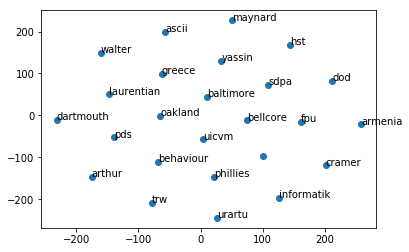

In [0]:
plt.scatter(tsne_data[:,0],tsne_data[:,1])
for i in range(len(words[:25]) - 1):
    plt.annotate(words[i], xy = (tsne_data[i][0],tsne_data[i][1]))
plt.show()